# RANSAC 







Lors de la mise en correspondance d'entités, il existe généralement des valeurs aberrantes, c'est-à-dire des correspondances de points qui ne correspondent pas correctement. De telles valeurs aberrantes sont causées par des changements de points de vue et les changements sont dus à l'éclairage. Le bruit de l'image, les occlisions ou le flou peuvent également provoquer des valeurs aberrantes.

![Matching Example](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_10/1_matching_example.png)
*Figure 1: Matching Example. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/08_multiple_view_geometry_2.pdf)*



### Échantillon aléatoire de consensus (RANSAC)

Une solution pour avoir de nombreuses valeurs aberrantes est la méthode RANSAC qui est la méthode standard d'ajustement des modèles en présence de valeurs aberrantes. Puisque nous avons un problème d’ajustement normal, cette solution peut être appliquée chaque fois que l’objectif est d’estimer les paramètres d’un modèle. Par conséquent, cela n'est pas exclusif à l'estimation de mouvement et peut également être appliqué par exemple à SFM, Calibration ou PnP et plus encore.

Le concept de base de RANSAC est qu'il échantillonne des points de manière aléatoire et tente d'ajuster un modèle qui décrit ces points. Ensuite, pour tous les points restants, l'erreur est calculée et le nombre de points à l'intérieur de la région actuelle autour de notre modèle/ligne est compté. Ensuite, le processus est répété. En fin de compte, nous sélectionnons comme modèle le modèle avec le plus de points à l'intérieur d'une certaine région.

Voici donc un exemple plus détaillé. Parcourez les images de gauche à droite. Étant donné un ensemble de points, nous sélectionnons deux points au hasard. Ensuite, nous ajustons un modèle à travers ces points. Dans cet exemple, nous traçons simplement une ligne. Ensuite, nous calculons l'erreur de tous les autres points par rapport à ce modèle. Dans notre cas, il s'agit simplement de la distance la plus courte entre notre modèle/ligne et le point. Ensuite, nous sélectionnons toutes les données qui soutiennent l'hypothèse de notre modèle actuel. Cela signifie que nous sélectionnons les points qui se situent à l'intérieur d'un certain seuil autour du modèle.

![Sampling and Fitting](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_10/3_random_sampling.png)
*Figure 3: Sampling and Fitting. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/08_multiple_view_geometry_2.pdf)*

Ce processus est ensuite répété pour de nombreux échantillons aléatoires différents.

![Repeating](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_10/4_repeating_process.png)
*Figure 4: Repeating. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/08_multiple_view_geometry_2.pdf)*

Après k itérations, nous sélectionnons le modèle qui a le plus de points de données dans sa région de support.


In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from stitch import *

In [2]:
rgb_l = cv2.cvtColor(cv2.imread("images/left.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("images/right.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)



In [3]:
md = cv2.SIFT_create()
# Trouvez des points d'intérêt et des fonctionnalités informatiques.
k0,des1 = md.detectAndCompute(gray_l, None)
k1,des2 = md.detectAndCompute(gray_r, None)

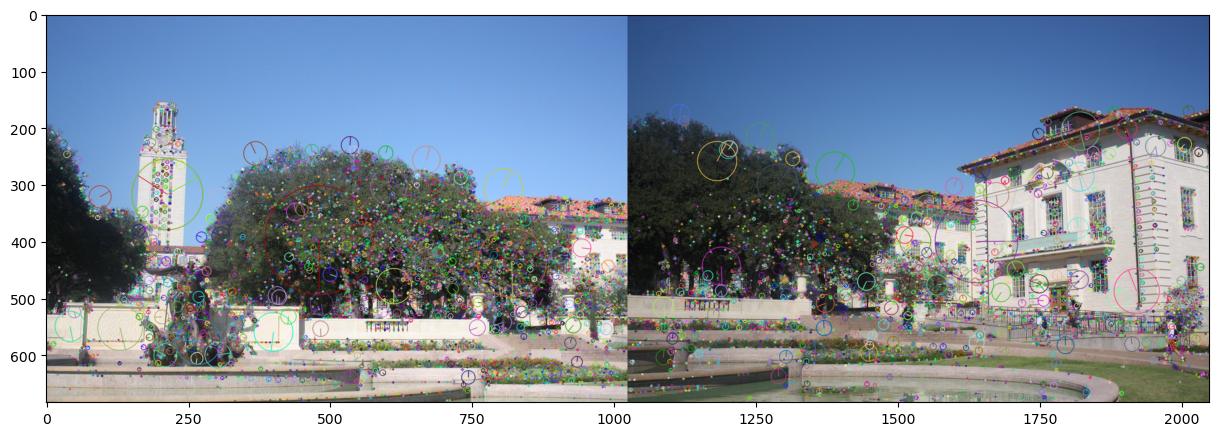

In [4]:
img0_kp= cv2.drawKeypoints(rgb_l.copy(), k0, rgb_l.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img1_kp=cv2.drawKeypoints(rgb_r.copy(), k1, rgb_r.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt_img = np.concatenate((img0_kp, img1_kp), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(plt_img)

In [5]:

# Paramètres FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
matchesMask = [[0,0] for i in range(len(matches))]
good = []
for i,(m,n) in enumerate(matches):
 if m.distance < 0.8*n.distance:
    good.append(m)
    matchesMask[i]=[1,0]


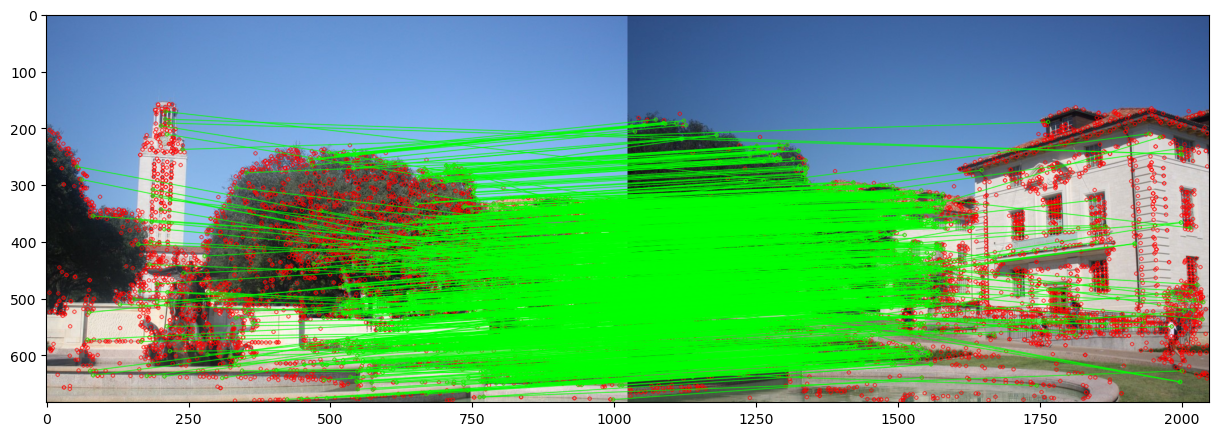

In [6]:
draw_params = dict(matchColor = (0,255,0),
 singlePointColor = (255,0,0),
 matchesMask = matchesMask,
 flags = cv2.DrawMatchesFlags_DEFAULT)
img = cv2.drawMatchesKnn(rgb_l.copy(),k0,rgb_r.copy(),k1,matches,None,**draw_params)
plt.figure(figsize=(15,15))
plt.imshow(img)

In [7]:
src_points = np.float32([k0[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_points = np.float32([k1[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)



In [8]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [9]:
iterations=2000
best_num_inliers=0

thershold=5
for it in tqdm(range(iterations)):
    sample_idxs=np.random.choice(range(len(src_points)), size=8, replace=False, p=None)
    
    pts1=src_points[sample_idxs]
    pts2=dst_points[sample_idxs]
    
    H, mask = cv2.findHomography(pts1,pts2,0)
    
    pts1_ = cv2.perspectiveTransform(src_points, H)
    rmse=np.linalg.norm(pts1_.reshape(-1,2)-dst_points.reshape(-1,2), axis=1)
    num_inliers=np.sum(rmse<=thershold)
    if num_inliers > best_num_inliers:
        best_num_inlier=num_inliers
        best_H=H
    


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4007.15it/s]


In [10]:
num_inliers/len(pts1_)

0.8877049180327868

In [11]:
print(best_H)

[[ 1.27075185e+00 -8.29411714e-02 -5.53671946e+02]
 [ 1.56551376e-01  1.20145699e+00 -1.56808792e+02]
 [ 2.58353500e-04  2.00436515e-05  1.00000000e+00]]


In [12]:
H2, mask=cv2.findHomography(src_points,dst_points,cv2.RANSAC,5)
np.mean(mask)

0.8877049180327868

In [13]:
print(H2)

[[ 1.29755597e+00 -7.39589673e-02 -5.73484659e+02]
 [ 1.69095053e-01  1.21994578e+00 -1.67967984e+02]
 [ 2.78689505e-04  2.15740926e-05  1.00000000e+00]]


In [14]:
filtred_pts1=src_points[rmse<=5]
filtred_pts2=dst_points[rmse<=5]